<a href="https://colab.research.google.com/github/Akshhxt/TensorFlow/blob/main/Transfer_Learning_in_TensorFlow(1)_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer learning**, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has **already learned** patterns on similar data to our own. This often results in achieving great results with less custom data.

What this means is, instead of hand-crafting our own neural network architectures or building them from scratch, we can utilise models which have worked for others.

And instead of training our own models from scratch on our own datasets, we can take the patterns a model has learned from datasets such as [ImageNet](http://www.image-net.org/) (millions of images of different objects) and use them as the foundation of our own. Doing this often leads to getting great results with less data.

Over the next few notebooks, we'll see the power of transfer learning in action.

## What we're going to cover

We're going to go through the following with TensorFlow:

- Introduce transfer learning (a way to beat all of our old self-built models)
- Using a smaller dataset to experiment faster (10% of training samples of 10 classes of food)
- Build a transfer learning feature extraction model using TensorFlow Hub
- Introduce the TensorBoard callback to track model training results
- Compare model results using TensorBoard

In [1]:
# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-03-17 17:15:10.645734


In [2]:
# Are we using a GPU?
!nvidia-smi

Sun Mar 17 17:15:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Downloading and becoming one with the data

In [3]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-03-17 17:15:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 173.194.194.207, 173.194.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   262MB/s    in 0.6s    

2024-03-17 17:15:13 (262 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

## Creating data loaders (preparing the data)

Now we've downloaded the data, let's use the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class along with the `flow_from_directory` method to load in our images.

In [5]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


Excellent! Loading in the data we can see we've got 750 images in the training dataset belonging to 10 classes (75 per class) and 2500 images in the test set belonging to 10 classes (250 per class).

## Setting up callbacks (things to run whilst our model trains)

Before we build a model, there's an important concept we're going to get familiar with because it's going to play a key role in our future model building experiments.

And that concept is **callbacks**.

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
* [**Experiment tracking with TensorBoard**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - log the performance of multiple models and then view and compare these models in a visual way on [TensorBoard](https://www.tensorflow.org/tensorboard) (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
* [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
* [**Early stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

We'll explore each of these overtime but for this notebook, we'll see how the TensorBoard callback can be used.

The TensorBoard callback can be accessed using [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard).

Its main functionality is saving a model's training performance metrics to a specified `log_dir`.

By default, logs are recorded every epoch using the `update_freq='epoch'` parameter. This is a good default since tracking model performance too often can slow down model training.

To track our modelling experiments using TensorBoard, let's create a function which creates a TensorBoard callback for us.

> 🔑 **Note:** We create a function for creating a TensorBoard callback because as we'll see later on, each model needs its own TensorBoard callback instance (so the function will create a new one each time it's run).



In [6]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

Because you're likely to run multiple experiments, it's a good idea to be able to track them in some way.

In our case, our function saves a model's performance logs to a directory named `[dir_name]/[experiment_name]/[current_timestamp]`, where:
* `dir_name` is the overall logs directory
* `experiment_name` is the particular experiment
* `current_timestamp` is the time the experiment started based on Python's [`datetime.datetime().now()`](https://docs.python.org/3/library/datetime.html#datetime.datetime.now)

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from [TensorFlow Hub](https://tfhub.dev/).

In fact, we're going to use two models from TensorFlow Hub:
1. [ResNetV2](https://arxiv.org/abs/1603.05027) -  a state of the art computer vision model architecture from 2016.
2. [EfficientNet](https://arxiv.org/abs/1905.11946) - a state of the art computer vision architecture from 2019.

State of the art means that at some point, both of these models have achieved the lowest error rate on [ImageNet (ILSVRC-2012-CLS)](http://www.image-net.org/), the gold standard of computer vision benchmarks.

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [9]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

Great! Now we've got a function for creating a model, we'll use it to first create a model using the ResNetV250 architecture as our feature extraction layer.

Once the model is instantiated, we'll compile it using `categorical_crossentropy` as our loss function, the Adam optimizer and accuracy as our metric.


In [10]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png)
*What our current model looks like. A ResNet50V2 backbone with a custom dense layer on top (10 classes instead of 1000 ImageNet classes). **Note:** The Image shows ResNet34 instead of ResNet50. **Image source:** https://arxiv.org/abs/1512.03385.*

Beautiful. Time to fit the model.

We've got the training data ready in `train_data_10_percent` as well as the test data saved as `test_data`.

But before we call the fit function, there's one more thing we're going to add, a callback. More specifically, a TensorBoard callback so we can track the performance of our model on TensorBoard.

We can add a callback to our model by using the `callbacks` parameter in the fit function.

In our case, we'll pass the `callbacks` parameter the `create_tensorboard_callback()` we created earlier with some specific inputs so we know what experiments we're running.

Let's keep this experiment short and train for 5 epochs.

In [11]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240317-171621
Epoch 1/5
24/24 [==============================] - 22s 585ms/step - loss: 1.9322 - accuracy: 0.3800 - val_loss: 1.2001 - val_accuracy: 0.6392
Epoch 2/5
24/24 [==============================] - 10s 424ms/step - loss: 0.9044 - accuracy: 0.7413 - val_loss: 0.8578 - val_accuracy: 0.7304
Epoch 3/5
24/24 [==============================] - 10s 448ms/step - loss: 0.6400 - accuracy: 0.8267 - val_loss: 0.7680 - val_accuracy: 0.7604
Epoch 4/5
24/24 [==============================] - 14s 599ms/step - loss: 0.4896 - accuracy: 0.8707 - val_loss: 0.7379 - val_accuracy: 0.7508
Epoch 5/5
24/24 [==============================] - 11s 451ms/step - loss: 0.3922 - accuracy: 0.9013 - val_loss: 0.6762 - val_accuracy: 0.7776


Wow!

It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...**with only 10 percent of the training images!**

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

Let's check out our model's training curves using our `plot_loss_curves` function.

In [12]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

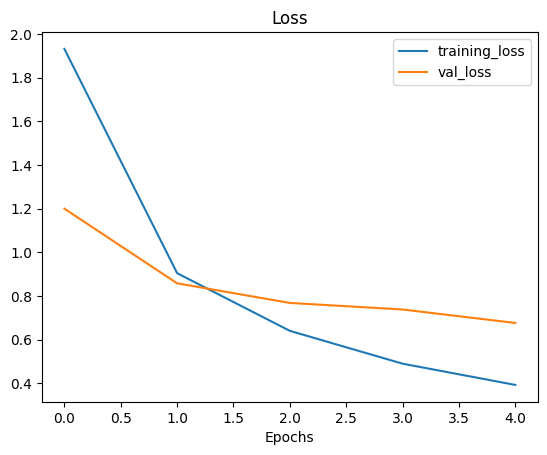

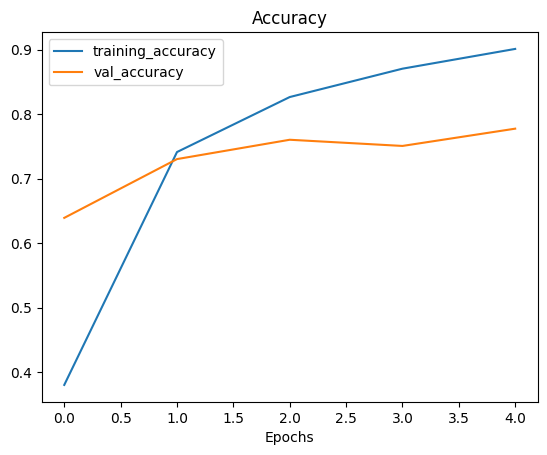

In [13]:
plot_loss_curves(resnet_history)

In [14]:
# Resnet summary
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


You can see the power of TensorFlow Hub here. The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set `trainable=False`, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

Okay, we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.

The setup will be the exact same as before, except for the `model_url` parameter in the `create_model()` function and the `experiment_name` parameter in the `create_tensorboard_callback()` function.

In [15]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240317-171818
Epoch 1/5
24/24 [==============================] - 24s 545ms/step - loss: 1.7898 - accuracy: 0.4773 - val_loss: 1.2736 - val_accuracy: 0.7408
Epoch 2/5
24/24 [==============================] - 10s 422ms/step - loss: 1.0246 - accuracy: 0.7907 - val_loss: 0.8601 - val_accuracy: 0.8228
Epoch 3/5
24/24 [==============================] - 10s 416ms/step - loss: 0.7329 - accuracy: 0.8413 - val_loss: 0.6977 - val_accuracy: 0.8392
Epoch 4/5
24/24 [==============================] - 10s 434ms/step - loss: 0.5958 - accuracy: 0.8653 - val_loss: 0.6134 - val_accuracy: 0.8592
Epoch 5/5
24/24 [==============================] - 10s 444ms/step - loss: 0.5054 - accuracy: 0.8933 - val_loss: 0.5592 - val_accuracy: 0.8652


Holy smokes! The EfficientNetB0 model does even better than the ResNetV250 model! Achieving over 85% accuracy on the test set...again **with only 10% of the training data**.

How cool is that?

With a couple of lines of code we're able to leverage state of the art models and adjust them to our own use case.

Let's check out the loss curves.

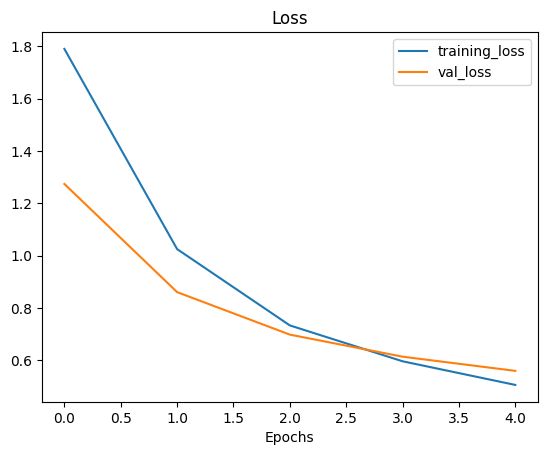

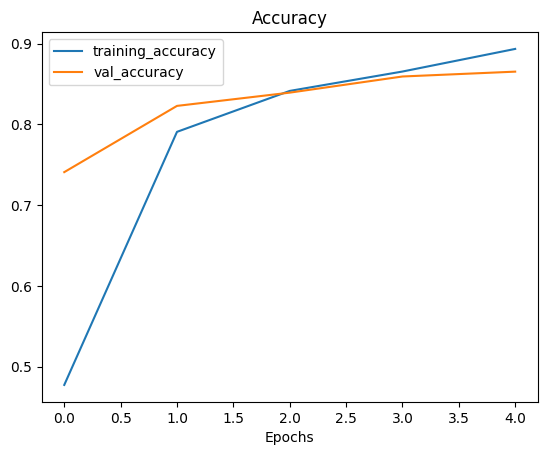

In [16]:
plot_loss_curves(efficientnet_history)

From the look of the EfficientNetB0 model's loss curves, it looks like if we kept training our model for longer, it might improve even further. Perhaps that's something you might want to try?

Let's check out the model summary.

In [17]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________
